In [14]:
import glob
import os
import copy
import numpy as np
import pandas as pd

import cv2
import pytesseract
from tkinter import Tk, filedialog
from skimage.metrics import structural_similarity

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

import matplotlib
import matplotlib.pylab as plt

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [2]:
def find_nearest(array, value, array_matching = np.nan):
    """
    Find the best match in an array.
        Optionally use the found index to retreive the value of an array matching the first one in shape.

    Parameters
    ----------
    array : list or np.array
        The array which is searched for the value.
    value : int, float, double
        The numeric value which is searched for. 
    array_matching : list or np.array, optional
        An array matching the shape of "array", which can optionally be used as output instead of "array". 

    Returns
    -------
    int, float, double
        The closest match of the searched array, or the element of the same index in an matching array.
    """

    array = np.asarray(array)
    # search for the smalles difference
    idx = (np.abs(array - value)).argmin()
    # use found index to return output
    if np.isnan(array_matching).all():
        return array[idx]
    else:
        return array_matching[idx]

In [3]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    """
    Resize an image and interpolate the resolution.

    Parameters
    ----------
    image : cv2.image 
        The image to resize.
    width : int
        Target width in pixel.
    height : int
        Target height in pixel. 
    inter : cv2 interpolation method
        Interpolation method to shrink or enlarge the image.

    Returns
    -------
    cv2.image
        The resized image.
    """
    
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [4]:
def convert_label_x(label, show_input = False, show_plots = True, force_manual=False):
    """
    Convert the image of a lable to characters.

    Parameters
    ----------
    label : cv2.image 
        The image to convert.
    show_input : bool
        Plot the input before processing.
    show_plots : bool
        Show image while processing. 
    force_manual : bool
        Set the convertion mode to manual for the user.

    Returns
    -------
    float
        The converted value.
    """
    out = []
    
    # Set up tesseract parameters for reading the labels of selected grid intersections
    # '--psm 6' -> "Assume a single uniform block of text." 
    # '--oem 3' -> default OCR (optical character recognition) engine
    # '-c tessedit_char_whitelist' -> use a whitelist to avoid wrongly read characters
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1' 

    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
        
    # Resizing the label for ideal readability:
    label = image_resize(label, height=100, inter=cv2.INTER_CUBIC)

    if force_manual:
        plt.imshow(label)
        plt.show()
        plt.close()
        return_str = input('please help me read this lable: ')
    else:
        # Enhancing the image to make it easier to read for tesseract:
        gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        thresh_val = 50
        thresh = cv2.threshold(blur, thresh_val, thresh_val, cv2.THRESH_BINARY)[1]

        # Separating the characters of the image -> this way it is easier to identify lower quality images
        # This done by looking for the spaces inbetween the characters. Their vertical sum should be mostly white
        # Sometimes the space between the characters is very small. Depending on the font, examples like "-4" are often seen as one character.
        edges = cv2.Canny(thresh,100,200)
        vertical_sum = np.sum(edges, axis=0)
        vertical_sum = vertical_sum != 0
        changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
        change_pts = np.nonzero(changes)[0]

        if show_plots:
            print('character detection')
            plt.imshow(thresh)
            for change in change_pts:
                plt.axvline(change+1)
            plt.show()
            plt.close()

        # Iterating through the parts of the image -> the single characters
        for i in range(len(change_pts)-1):
            start = change_pts[i]
            end =  change_pts[i+1]
            if start != end and end-start > 10:
                cut = label[:, start:end]
                cut = cv2.copyMakeBorder(
                         cut, 
                         1, 
                         1, 
                         20, 
                         20, 
                         cv2.BORDER_CONSTANT, 
                         value= [175,175,175]
                      )

                # Changing back to grey for identification
                gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (5,5), 0)
                thresh = cv2.threshold(blur, 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

                # Morph open to remove noise and invert image
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
                opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
                inverted = 255 - opening
                if show_plots:
                    plt.imshow(inverted)
                    plt.show()
                    plt.close()
                out_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)

                # Catch translation encoding errors:
                if out_val == '\x0c':
                    out.append('-')
                else:
                    out.append( out_val.split('\n\x0c')[0])

        # Rebuilding the whole lable from its parts:            
        return_str = ''.join(out)

    # Check for lost "-" and search for them the manually identified db:    
    minus_signs = [pos for pos, char in enumerate(return_str) if char == '-']
    if (minus_signs != [0]) and (minus_signs != []):
        match_found = False
        for id_img in glob.glob('./identified_images/*.png'):
            # Load images from manually identified db:
            to_compare_to = cv2.imread(id_img)
            if np.all(label == to_compare_to):
                match_found = True
                if '_' in id_img.split('./identified_images/')[-1]:
                    return_str = id_img.split('./identified_images/')[-1].split('_')[0]
                else:
                    return_str = id_img.split('.png')[0].split('./identified_images/')[-1]
                break

        if match_found:
            return float(return_str)
        # if no match is found in the manually identified db, the user is asked to manually identifiy. 
        else:
            plt.imshow(label)
            plt.show()
            plt.close()
            print(minus_signs)
            return_str = input('please help me read this lable: ')
            out_nr = 0
            while True:
                out_name = './identified_images/'+return_str+'_'+str(out_nr)+'.png'
                out_nr += 1
                if not os.path.isdir(out_name):
                    break
            
            cv2.imwrite(out_name, label)
    
    return float(return_str)

    
def convert_label_y(label, show_input = False, show_plots = True, force_manual=False):
    """
    Convert the image of a lable to characters.

    Parameters
    ----------
    label : cv2.image 
        The image to convert.
    show_input : bool
        Plot the input before processing.
    show_plots : bool
        Show image while processing. 
    force_manual : bool
        Set the convertion mode to manual for the user.

    Returns
    -------
    float
        The converted value.
    """

    out = []

    # Set up tesseract parameters for reading the labels of selected grid intersections
    # '--psm 6' -> "Assume a single uniform block of text." 
    # '--oem 3' -> default OCR (optical character recognition) engine
    # '-c tessedit_char_whitelist' -> use a whitelist to avoid wrongly read characters
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1' #'--psm 6' # 'outputbase digits'

    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
    
    # Resizing the label for ideal readability:    
    label = image_resize(label, height=100, inter=cv2.INTER_CUBIC)
    
    if force_manual:
        plt.imshow(label)
        plt.show()
        plt.close()
        return_str = input('please help me read this lable: ')
    else:
        # Enhancing the image to make it easier to read for tesseract:
        gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        thresh_val = 50
        thresh = cv2.threshold(blur, thresh_val, thresh_val, cv2.THRESH_BINARY)[1]

        # Separating the characters of the image -> this way it is easier to identify lower quality images
        # This done by looking for the spaces inbetween the characters. Their vertical sum should be mostly white
        # Sometimes the space between the characters is very small. Depending on the font, examples like "-4" are often seen as one character.
        edges = cv2.Canny(thresh,100,200)
        vertical_sum = np.sum(edges, axis=0)
        vertical_sum = vertical_sum != 0
        changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
        change_pts = np.nonzero(changes)[0]

        if show_plots:
            print('character detection')
            plt.imshow(thresh)
            for change in change_pts:
                plt.axvline(change+1)
            plt.show()
            plt.close()

        # Iterating through the parts of the image -> the single characters
        for i in range(len(change_pts)-1):
            start = change_pts[i]
            end =  change_pts[i+1]
            if start != end and end-start > 10:
                cut = label[:, start:end]
                cut = cv2.copyMakeBorder(
                         cut, 
                         1, 
                         1, 
                         20, 
                         20, 
                         cv2.BORDER_CONSTANT, 
                         value= [175,175,175]
                      )
                
                # Changing back to grey for identification
                gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (5,5), 0)
                thresh = cv2.threshold(blur, 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

                # Morph open to remove noise and invert image
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
                opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
                inverted = 255 - opening
                if show_plots:
                    plt.imshow(inverted)
                    plt.show()
                    plt.close()
                out_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)

                # Catch translation encoding errors:
                if out_val == '\x0c':
                    out.append('')
                else:
                    out.append( out_val.split('\n\x0c')[0])

        # Rebuilding the whole lable from its parts:            
        return_str = ''.join(out)

    # Check for wrongly identified characters:       
    error_characters = [pos for pos, char in enumerate(return_str) if not np.isin(char, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.'])]
    if (error_characters != [0]) and (error_characters != []):
        for id_img in glob.glob('./identified_images/*.png'):
            # Load images from manually identified db and check how similar they are:
            to_compare_to = cv2.imread(id_img)

            # Compute SSIM between the two images
            (score, diff) = structural_similarity(label, to_compare_to, full=True)
            print("Image Similarity: {:.4f}%".format(score * 100))
        plt.imshow(label)
        plt.show()
        plt.close()
        print(error_characters)
        # Start manual identification:
        return_str = input('please help me read this lable: ')
        out_nr = 0
        while True:
            out_name = './identified_images/'+return_str+'_'+str(out_nr)+'.png'
            out_nr += 1
            if not os.path.isdir(out_name):
                break

        cv2.imwrite(out_name, label)

    # Usecase specific correction -> catch reduced axis labels (where the whole axis is displayed in e.g. 10³)
    if len(return_str) < 3:
        val = float(return_str)*1000
    else:
        val = float(return_str)
    return val


In [5]:
def digitize(file, height_input = False, show_plots = True):  
    """
    Digitize an image into data.

    Parameters
    ----------
    file : str 
        Path to the image file. 
    height_input : bool
        True if the image shows height data on the y axis.
        If not, it is assumed, that pressure is displayed on the y axis. 
    show_plots : bool
        If True, the script will show all intermediate plots.

    Returns
    -------
    pandas.Dataframe
        The digitized data - also saved to file.
    """

    # Settings for plots:
    matplotlib.rcParams["figure.figsize"] = (4, 3)
    %matplotlib inline

    # Load the image
    print(file)
    img = cv2.imread(file)
    if show_plots:
        print('Loaded image:')
        plt.imshow(img)
        plt.show()
        plt.close()

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show_plots:
        print('Greyscale:')
        plt.imshow(gray)
        plt.show()
        plt.close()

    # Apply a threshold to create a binary image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find the contour with the largest area (i.e., the plot data)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    plot_only = img[y+10:y+h-1, x+1:x+w-1]
    relative_y = y+10
    relative_x = x+1
    relative_y_xaxis =  y+h-1

    if show_plots:
        print('Cut main part:')
        plt.imshow(plot_only)
        plt.show()
        plt.close()

    # Save the cropped image
    cv2.imwrite('test_plot_only.png', plot_only)

    # Check if there is really data in the plot, otherwise this image is skipped
    if np.mean(plot_only) <= 10:
        print('All black')
        return 0

    # Convert the contour to a numpy array and transpose it
    plot_data = largest_contour.squeeze().T

    # Check if the meta data info box has text in it - if not, no valid data is displayed in this image -> return.
    image = img[ 1269:1282, 20:500]
    if show_plots:
        print('Check if valid screenshot:')
        plt.imshow(image)
        plt.show()
        plt.close()
    if np.mean(image) >= 205:
        print('All white')
        return 0

    # Make characters sharper and distinguishable from blur:
    image_l = image_resize(image, height = 50)
    gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    if show_plots:
        print('Improved metadata:')
        plt.imshow(inverted)
        plt.show()
        plt.close()

    # Read meta data line:
    data = pytesseract.image_to_string(inverted, lang='eng', config= '--psm 7')
    
    # Open plot image only - has been cropped before: 
    im = cv2.imread("test_plot_only.png")

    # Define lower and upper limits of our blue
    BlueMax = np.array([128, 255, 255], np.uint8)
    BlueMin = np.array([90, 50, 70], np.uint8)

    # Go to HSV colourspace and get mask of blue pixels
    HSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(HSV, BlueMin, BlueMax)

    # Make all pixels in mask white -> the result is only the grid remaining
    grid = copy.copy(im)
    grid[mask == 0] = [255, 255, 255]
    grid[0:, 0:15] = [255, 255, 255]

    # Make all the pixels not in mask white -> the result is only the graph
    im[mask > 0] = [255, 255, 255]
    im[0:100, 0:15] = [255, 255, 255]
    im[-2:, :] = [255, 255, 255]

    # Save both separated parts of the image
    cv2.imwrite("test_grid_only.png", grid)
    cv2.imwrite("test_data_only.png", im)

    if show_plots:
        print('Graph only:')
        plt.imshow(im)
        plt.show()
        plt.close()
    if show_plots:
        print('Grid only:')
        plt.imshow(grid)
        plt.show()
        plt.close()

    # Start analyzing the grid by converting everything into grays
    grid = cv2.imread('test_grid_only.png')
    gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    # Start analyzing the grid by converting everything into grays
    dst = cv2.cornerHarris(gray, 5,19,0.07)
    dst = cv2.dilate(dst, None)

    if show_plots:
        print('Grid intersections:')
        plt.imshow(dst)
        plt.show()
        plt.close()

    # Get coordinates of intersections
    ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # Find centroids of the intersections 
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # Define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 
                0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids[1:]),(5,5), 
          (-1,-1),criteria)
    
    # Get the intersections, but only within the inner 64% of the image, to avoid artifacts from the very outside of the plot 
    for corner in corners:
        grid[int(corner[1]), int(corner[0])] = [0, 0, 255]
    corner_coords = np.asarray(corners, dtype = int)
    corner_coords = corner_coords[corner_coords[:,0] < np.max(corner_coords[:,0]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,1] < np.max(corner_coords[:,1]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,0] > np.max(corner_coords[:,0]) * 0.1]
    corner_coords = corner_coords[corner_coords[:,1] > np.max(corner_coords[:,1]) * 0.1]
    
    # Create a image with drawn circles, where intersections are - just as a refference
    for co in corner_coords:
        grid = cv2.circle(grid, co, radius=4, color=(255, 0, 0), thickness=-1)

    # choosing 2 of the intersection -> once with pixel sum maximum and once with pixel sum minimum -> diagonal with largest distance
    grid = cv2.imread('test_grid_only.png')
    maxcoord = np.argmax(np.sum(corner_coords, axis = 1))
    mincoord = np.argmin(np.sum(corner_coords, axis = 1))

    # Mark the two selected intersections:
    coords_low = corner_coords[mincoord]
    coords_high = corner_coords[maxcoord]
    grid = cv2.circle(grid, coords_low, radius=4, color=(0, 0, 255), thickness=-1)
    grid = cv2.circle(grid, coords_high, radius=4, color=(0, 0, 255), thickness=-1)

    # The two selected grid intersections and their two labels (x & y) will be analysed
    low_y_label = img[relative_y + coords_low[1]-10: relative_y + coords_low[1]+10, relative_x-45:relative_x-1]
    low_y_val = convert_label_y(low_y_label, show_input = False, show_plots = show_plots)
    print(low_y_val)
    
    high_y_label = img[relative_y + coords_high[1]-10: relative_y + coords_high[1]+10, relative_x-45:relative_x-1]
    high_y_val = convert_label_y(high_y_label, show_input = False, show_plots = show_plots)
    print(high_y_val)

    low_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_low[0]-20:relative_x+coords_low[0]+30]
    low_x_val = convert_label_x(low_x_label, show_input = False, show_plots = show_plots)
    print(low_x_val)    
    
    high_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_high[0]-30:relative_x+coords_high[0]+30]
    high_x_val = convert_label_x(high_x_label, show_input = False, show_plots = show_plots)
    print(high_x_val)
    
    print()
    
    # Quality controll of read data, "-" often go missing, if a value lower on the axis is larger than the following one, it can be assumed, that the "-" got lost in the process:
    if low_x_val > 0 and low_x_val > high_x_val:
        low_x_val = str(float(low_x_val) * -1)
        print('changed to: ', low_x_val)
    
    # Converting axis labels to data
    xa_p = [coords_low[0], coords_high[0]]
    xa_v = [273.15+low_x_val, 273.15+high_x_val]
    ya_p = [coords_low[1], coords_high[1]]
    ya_v = [low_y_val, high_y_val]
    
    ###                                                                                         ###
    # Now it is necessary to convert the coordinates of the analysed values into a function.      #  
    # With that function all points of the graph can then be converted from pixel to data values. #
    ###                                                                                         ###

    # Calculation of axis functions
    # x-axis
    x1 = xa_p[0]
    a = xa_v[0]
    x2 = xa_p[1]
    b = xa_v[1]

    m_T = (b - a) / (x2 - x1)
    c_T = a - m_T * x1
    def T(x):
        return m_T * x + c_T

    # y-axis
    if height_input:
        y1 = ya_p[0]
        ap = ya_v[0]
        y2 = ya_p[1]
        bp = ya_v[1]
    else: 
        y1 = ya_p[0]
        ap = np.log(ya_v[0])
        y2 = ya_p[1]
        bp = np.log(ya_v[1])

    m = (bp - ap) / (y2 - y1)
    c = ap - m * y1
    def P(x):
        return m * x + c
    
    # Selection of data points via contour of graph:
    graph = cv2.imread('test_data_only.png')
    edge = cv2.Canny(graph, 30, 200) 
    ans = []
    for y in range(0, edge.shape[0]):
        for x in range(0, edge.shape[1]):
            if edge[y, x] != 0:
                ans = ans + [[x, y]]
    ans = np.array(ans)
    if len(ans) == 0:
        return 0

    for co in ans[:]:
        image = cv2.circle(graph, co, radius=4, color=(255, 0, 0), thickness=-1)

    # Check that all parts of the graph are different and not too close toghter -> avoid false increase of resoultion. 
    unique_steps = []
    for i in range(np.min(ans[:,1]), np.max(ans[:,1])+1):
        step = ans[ans[:,1] == i]
        if len(step) > 1:
            mean_step = (np.mean(step, axis=0))
            unique_steps.append([int(mean_step[0]), int(mean_step[1])])
        elif len(step) == 1:
            unique_steps.append([int(step[0][0]), (step[0][1])])

    # Transform pixel points to data
    out = {}
    if height_input:
        out['press'] = P(np.array(unique_steps)[:,1])
    else:
        out['press'] = np.exp(P(np.array(unique_steps)[:,1]))
    out['temp'] = T(np.array(unique_steps)[:,0])

    # Write converted data into a dataframe to save it. 
    df = pd.DataFrame.from_dict(out)
    df = df.sort_values('press')

    # Check existing output directories
    if not os.path.isdir('output_height'):
        os.mkdir('output_height')

    if not os.path.isdir('output'):
        os.mkdir('output')
        
    if height_input:
        df.to_csv('./output_height/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    else:
        df.to_csv('./output/' + file.split('sc_')[-1].split('.png')[0]+'.csv')

    return df

./zoomed_data/sc_Vaisala_1_1_.png
Loaded image:


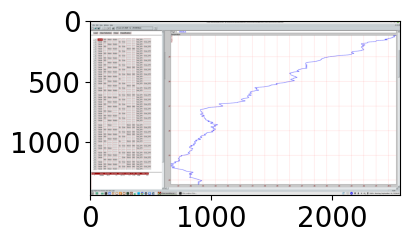

Greyscale:


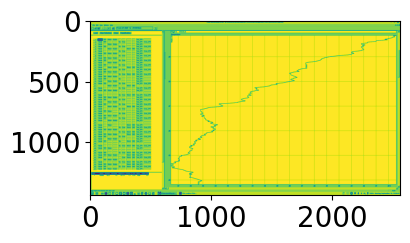

Cut main part:


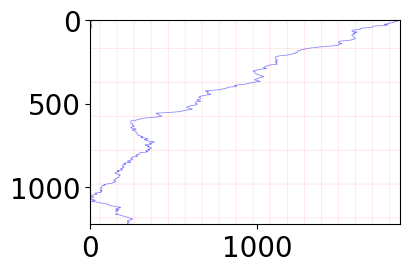

Check if valid screenshot:


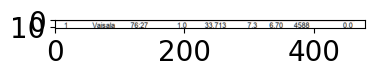

Improved metadata:


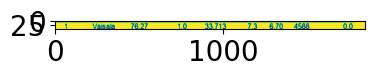

PermissionError: [Errno 13] Permission denied: '/srvfs/home/federico/.conda/envs/WORK_aurora/bin/tesseract'

In [15]:
for sonde in ['Vaisala',]: #'Vais_GPS', 'SRS', 'Sip', 'Modem', 'MKII', 'Meisei', 'Graw_GPS', 'Graw', '3therm']:
    for i in glob.glob('./zoomed_data/sc_'+ sonde +'_1_1_.png')[:]: 
        df = digitize(i, height_input = True, show_plots=True)

In [12]:
df

,press,temp
1222,23836.004932,217.756993
1221,23840.937115,217.747203
1220,23845.869297,217.747203
1219,23850.801480,217.747203
1218,23855.733662,217.747203
...,...,...
4,29843.403206,233.548601
3,29848.335388,233.577972
2,29853.267571,233.626923
1,29858.199753,233.675874
